In [ ]:
import pandas as pd
import time
import numpy as np
from pytrends.request import TrendReq
from tqdm.notebook import tqdm

df = pd.read_csv("TGDT_per_movie_data_cleaned_plus_feature.csv")

# Google Trends 검색용 키워드 생성
# 'movieNm_detail' (한글 제목)이 있으면 사용, 없으면 'movieNmEn' (영문 제목) 사용
df['google_keyword'] = df['movieNm_detail'].fillna(df['movieNmEn'])

# 결과를 저장할 피처 초기화
df['google_trend_max'] = np.nan           # 최대 검색량 (0~100 사이)
df['google_trend_ratio'] = np.nan         # 관심도 변화율 (개봉 전 관심도 상승폭)

# 트렌드 수집 함수
pytrends = TrendReq(hl='ko', tz=540)

def fetch_trend_features(keyword, open_date, window_pre=30, window_post=7):
    """
    주어진 영화 키워드와 개봉일을 기준으로 Google Trends 관심도 데이터를 가져와
    최대 검색량 및 관심도 변화율을 계산합니다.
    - window_pre: 개봉 전 분석 기간 (기본 30일)
    - window_post: 개봉 후 포함 기간 (기본 7일)
    """
    try:
        # 개봉일을 기준으로 검색 기간 설정
        start_date = pd.to_datetime(open_date) - pd.Timedelta(days=window_pre)
        end_date = pd.to_datetime(open_date) + pd.Timedelta(days=window_post)
        timeframe = f"{start_date.strftime('%Y-%m-%d')} {end_date.strftime('%Y-%m-%d')}"
        # Google Trends 데이터 요청
        pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='KR')
         # 검색 트렌드 시계열 데이터 수집
        df_trend = pytrends.interest_over_time()
        if df_trend.empty or keyword not in df_trend.columns:
            return 0.0, 0.0
        # 피처1: 최대 검색량 (0~100)
        series = df_trend[keyword]
        trend_max = float(series.max())

        # 피처2: 관심도 변화율
        # - 초기(개봉 30~24일 전 평균) vs 직전(개봉 7~1일 전 평균)
        # - 검색량 증가율 계산
        ratio = float(((series.iloc[-8:-1].mean()) - (series.iloc[:7].mean())) / (series.iloc[:7].mean() + 1e-5))
        return trend_max, ratio
    except Exception:
        return 0.0, 0.0

# 전체 영화에 대해 피처 계산 적용
for idx in tqdm(df.index, desc="Processing Movies"):
    row = df.loc[idx]
    keyword = row['google_keyword']
    openDt = row['openDt']
    if pd.notnull(keyword) and pd.notnull(openDt):
        max_trend, ratio = fetch_trend_features(keyword, openDt)
        df.at[idx, 'google_trend_max'] = max_trend
        df.at[idx, 'google_trend_ratio'] = ratio
        time.sleep(1.2)




Processing Movies:   0%|          | 0/2348 [00:00<?, ?it/s]

In [5]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance
import matplotlib.pyplot as plt

In [41]:
df = pd.read_csv("TGDT_per_movie_data_cleaned_plus_feature.csv")

In [44]:
#로그 변환 피처 추가
df['log_google_trend_ratio'] = np.log1p(df['google_trend_ratio'])

In [52]:
# 모델링용 피처 선택
features = [
    'log_salesAmt','log_showCnt', 'log_scrnCnt', 'showTm',
    'sales_per_screen','sales_per_show','screen_per_show',
    'has_main_director', 'has_main_actor', 
    'has_main_genre',
     'log_google_trend_ratio', #'plot_sentiment_score'
]

In [53]:
# 결측 제거 후 데이터 분할
df_model = df.dropna(subset=features + ['log_누적관람객수'])
X = df_model[features]
y = df_model['log_누적관람객수']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
# XGBoost 회귀 모델 학습
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

<Figure size 1000x600 with 0 Axes>

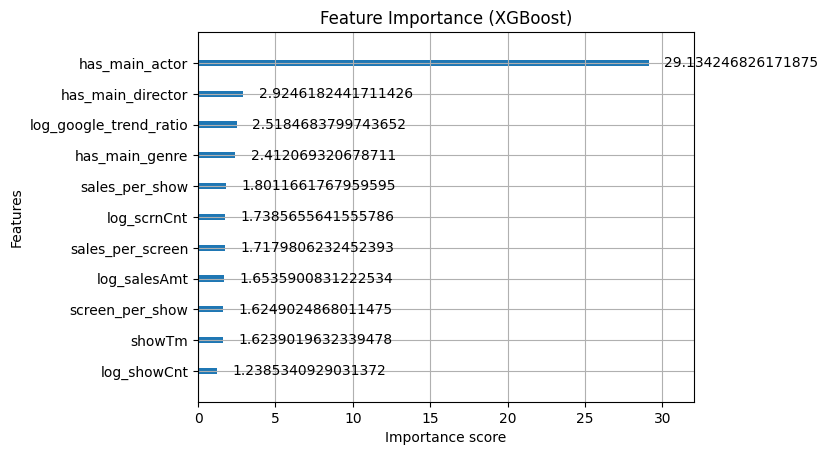

In [55]:
#피처 중요도 시각화
plt.figure(figsize=(10, 6))
plot_importance(model, importance_type='gain', max_num_features=15)
plt.title("Feature Importance (XGBoost)")
plt.show()

In [56]:
y_pred = model.predict(X_test)

In [57]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)


In [58]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


RMSE: 1.9845
R² Score: 0.2310


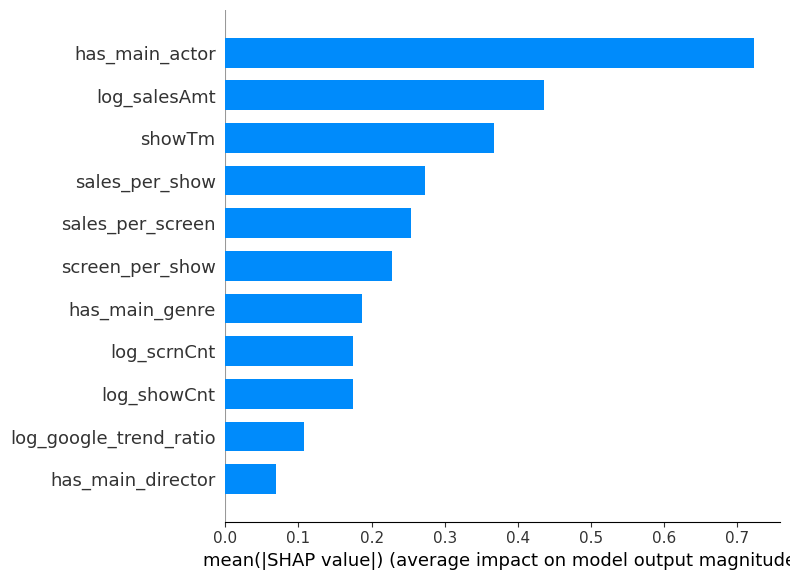

In [59]:
import shap

# SHAP 해석기 준비
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# 요약 플롯 (변수별 기여도 바형 그래프)
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [60]:
df.to_csv("TGDT_per_movie_data_cleaned_plus_feature.csv", index=False, encoding='utf-8-sig')